Import libraries

In [2]:
import re
import subprocess
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import os
import functools 
import PIL
from sklearn.decomposition import PCA

In [27]:
import warnings
warnings.filterwarnings('ignore')

List of directories

In [3]:
dirs = [x[0] for x in os.walk('orl_faces')][1:]

Storing all the images

In [4]:
images = []
for i in range(1,41):
  dir_ = 'orl_faces/s'+str(i)
  for j in range(1,11):
    file_ = str(j) + '.pgm'
    if os.path.isfile(os.path.join(dir_, file_)):
      images.append(np.asarray(PIL.Image.open(os.path.join(dir_, file_))))
images = np.array(images)

In [5]:
images.shape

(400, 112, 92)

Function to plot images

In [6]:
def plot_images(images):
  image = functools.reduce(lambda a, b: np.concatenate((a, b), axis=0),[functools.reduce(lambda a, b: np.concatenate((a, b), axis=1),[images[i*10 + j] for j in range(10)]) for i in range(40)])
  fig, ax = plt.subplots(figsize=(200, 50))
  ax.imshow(image, interpolation='nearest', cmap='gray')
  # Hide grid lines
  ax.grid(False)

  # Hide axes ticks
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()

Plotting the images

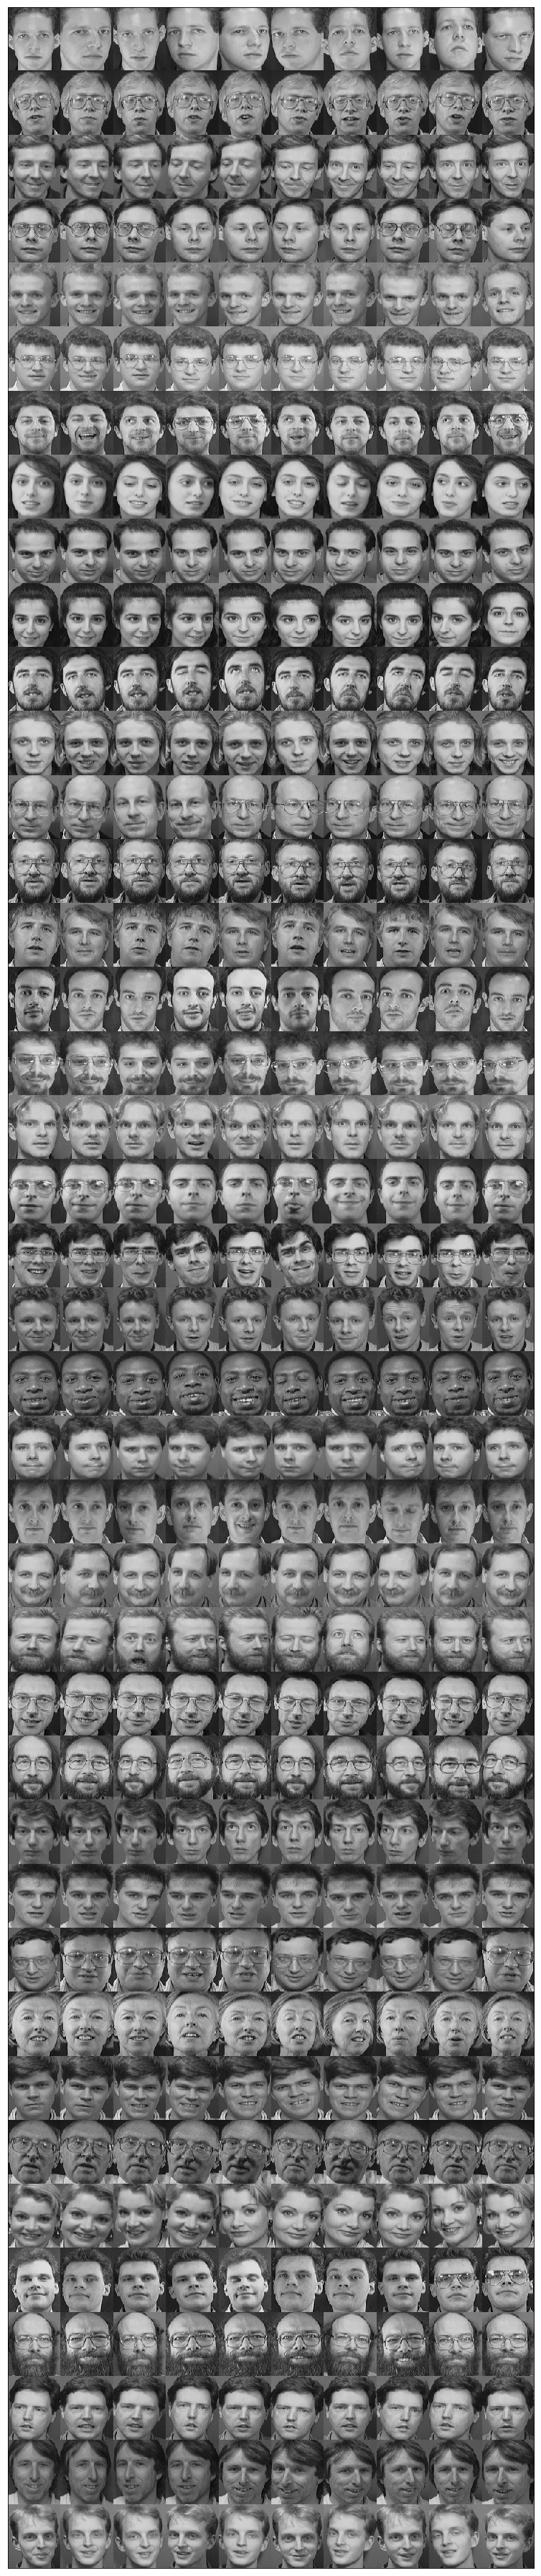

In [7]:
plot_images(images)

Flatten all the images

In [8]:
images_f = images.reshape(400, -1)

In [9]:
images_f.shape

(400, 10304)

Lables for all images

In [10]:
l = np.array([(x//10)+1 for x in range(400)])

In [11]:
l.shape

(400,)

X be flatten images
y be the lables

In [12]:
X = images_f
y = l

In [13]:
X = pd.DataFrame(X) 
y = pd.DataFrame(y)

Create a logistic regression model

In [28]:
clf = LogisticRegression()

A function to do PCA which takes data and percentage of variance to be covered so that it returns reduced data and number of required components

In [29]:
def do_pca(X, v):
  pca = PCA(v)
  X_proj = pca.fit_transform(X)
  X_app = pca.inverse_transform(X_proj)
  images = X_app.reshape(400, 112, 92)
  return X_proj, pca.n_components_

A function to do K-Fold validation  which takes input and lables and variance to be covered.

In [30]:
def do_kfold(X, y, v):
  X, n = do_pca(X.values, v)
  X = pd.DataFrame(X)
  cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
  results = pd.DataFrame(columns=['training_score', 'test_score'])
  f1_s, precision_s, recall_s = [], [], []
  for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    y_pred = clf.predict(X.iloc[test])
    y_true = y.iloc[test]
    score = clf.score(X.iloc[test], y.iloc[test])
    f1, precision, recall, support = precision_recall_fscore_support(y_true, y_pred)
    f1_s.append(f1)
    precision_s.append(precision)
    recall_s.append(recall)
  print('perclass mean')
  print('f1_acore:', np.average(f1_s, axis=0))
  print('precision:', np.average(precision_s, axis=0))
  print('recall:', np.average(recall_s, axis=0))

Doing Logistic regression Kfold cross validation

In [32]:
do_kfold(X, y, 0.7)

perclass mean
f1_acore: [0.8        0.93333333 1.         0.93333333 0.83333333 1.
 0.9        0.86666667 1.         1.         1.         1.
 0.93333333 1.         0.93333333 1.         0.93333333 0.8
 0.9        1.         1.         1.         1.         0.93333333
 1.         1.         1.         0.93333333 1.         0.93333333
 1.         1.         1.         1.         0.63333333 0.8
 0.93333333 1.         0.93333333 0.9       ]
precision: [0.7 1.  1.  0.9 0.9 1.  1.  1.  1.  0.9 1.  1.  0.9 1.  1.  1.  1.  1.
 0.9 1.  1.  1.  1.  1.  1.  0.9 0.9 0.7 1.  1.  1.  0.9 0.9 1.  0.6 0.8
 1.  1.  1.  0.7]
recall: [0.73333333 0.96       1.         0.89333333 0.86       1.
 0.93333333 0.92       1.         0.93333333 1.         1.
 0.89333333 1.         0.96       1.         0.96       0.88
 0.9        1.         1.         1.         1.         0.96
 1.         0.93333333 0.93333333 0.76       1.         0.96
 1.         0.93333333 0.93333333 1.         0.56       0.8
 0.96       1. 